# Parsing Data

In this notebook, we take our dataset that we sourced by extracting the movie ID’s from the IMDB dataset. We then used that to parse information related to a movie including it’s title, year, language, genres and the associated poster. From that data, we clean the dataset in this notebook and save it in relevant files in order to access them later.

In [0]:
# Imports

import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
from time import time
import io
import re
from csv import reader
from datetime import datetime
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Check if the data loaded properly
!tail -5 '/content/drive/My Drive/w266-FinalProject/data/imdb_dataset.csv'

"tt8404272","How Long Will I Love U","2018","[Comedy, Fantasy, Romance]","Mandarin","https://w266-final-project.s3.amazonaws.com/thumbnails/tt8404272.jpg","A woman from 2018 and a man from 1999 wake up in the same bed. They discover they can time travel using the bedroom door, and make changes to their eras, but that their destinies may not be in their own hands."
"tt9253188","Kavacham","2018","[Action, Thriller]","Telugu","https://w266-final-project.s3.amazonaws.com/thumbnails/tt9253188.jpg","A police officer from Vizag finds himself in a rut when false allegations are levied against him. He has 24 hours now to prove his innocence."
"tt8590896","Geetha Govindam","2018","[Drama, Romance]","Telugu","https://w266-final-project.s3.amazonaws.com/thumbnails/tt8590896.jpg","A charming young professor, Vijay Govind, has a dream of marrying a traditional woman. He sees Geetha in a temple and falls in love with her. He meets her again when he travels to his hometown in a bus. He impresses her a

In [0]:
# Convert csv file to pandas dataframe
df = pd.read_csv('/content/drive/My Drive/w266-FinalProject/data/imdb_dataset.csv')
df.head()

,movieid,moviename,year,genre,language,thumbnail,movieplot
0,tt0007610,'49-'17,1917,"[Drama, Western]",English,https://w266-final-project.s3.amazonaws.com/th...,A judge who had taken part in the gold rush of...
1,tt0005078,The Cheat,1915,"[Drama, Romance]",English,https://w266-final-project.s3.amazonaws.com/th...,"Richard Hardy, a hardworking stockbroker, labo..."
2,tt0007257,Reggie Mixes In,1916,"[Action, Comedy, Drama]",English,https://w266-final-project.s3.amazonaws.com/th...,"Reggie, a wealthy young man about town, is eag..."
3,tt0008011,A Girl's Folly,1917,[Comedy],NaN,https://w266-final-project.s3.amazonaws.com/th...,"Living in the country with her widowed mother,..."
4,tt0003772,Cinderella,1914,"[Fantasy, Drama]",English,https://w266-final-project.s3.amazonaws.com/th...,Based on the fairy tale: Cinderella is mistrea...


In [0]:
# Create a new column genre_list that is a list of strings for each movie
def create_genre_list():
  new_list = []
  for res in df.genre:
    result = [x.strip() for x in res.strip('][').split(', ')]
    new_list.append(result)
  return new_list

new_list = create_genre_list()
df.loc[:,'genre_list'] = new_list
df.head()

,movieid,moviename,year,genre,language,thumbnail,movieplot,genre_list
0,tt0007610,'49-'17,1917,"[Drama, Western]",English,https://w266-final-project.s3.amazonaws.com/th...,A judge who had taken part in the gold rush of...,"[Drama, Western]"
1,tt0005078,The Cheat,1915,"[Drama, Romance]",English,https://w266-final-project.s3.amazonaws.com/th...,"Richard Hardy, a hardworking stockbroker, labo...","[Drama, Romance]"
2,tt0007257,Reggie Mixes In,1916,"[Action, Comedy, Drama]",English,https://w266-final-project.s3.amazonaws.com/th...,"Reggie, a wealthy young man about town, is eag...","[Action, Comedy, Drama]"
3,tt0008011,A Girl's Folly,1917,[Comedy],NaN,https://w266-final-project.s3.amazonaws.com/th...,"Living in the country with her widowed mother,...",[Comedy]
4,tt0003772,Cinderella,1914,"[Fantasy, Drama]",English,https://w266-final-project.s3.amazonaws.com/th...,Based on the fairy tale: Cinderella is mistrea...,"[Fantasy, Drama]"


In [0]:
# Remove rows that don't have any genre's associated
df = df[~(df['genre_list'].str.len() == 0)]
df = df.loc[~(df.genre == '[]'),:]

df.head()

,movieid,moviename,year,genre,language,thumbnail,movieplot,genre_list
0,tt0007610,'49-'17,1917,"[Drama, Western]",English,https://w266-final-project.s3.amazonaws.com/th...,A judge who had taken part in the gold rush of...,"[Drama, Western]"
1,tt0005078,The Cheat,1915,"[Drama, Romance]",English,https://w266-final-project.s3.amazonaws.com/th...,"Richard Hardy, a hardworking stockbroker, labo...","[Drama, Romance]"
2,tt0007257,Reggie Mixes In,1916,"[Action, Comedy, Drama]",English,https://w266-final-project.s3.amazonaws.com/th...,"Reggie, a wealthy young man about town, is eag...","[Action, Comedy, Drama]"
3,tt0008011,A Girl's Folly,1917,[Comedy],NaN,https://w266-final-project.s3.amazonaws.com/th...,"Living in the country with her widowed mother,...",[Comedy]
4,tt0003772,Cinderella,1914,"[Fantasy, Drama]",English,https://w266-final-project.s3.amazonaws.com/th...,Based on the fairy tale: Cinderella is mistrea...,"[Fantasy, Drama]"


In [0]:
# Create a new column genre_list that is a list of strings for each movie
def plot_length():
  new_list = []
  for res in df.movieplot:
    new_list.append(len(res.split(" ")))
  return new_list

plot_len_list = plot_length()
df.loc[:,'plot_len'] = plot_len_list
df.head()

,movieid,moviename,year,genre,language,thumbnail,movieplot,genre_list,plot_len
0,tt0007610,'49-'17,1917,"[Drama, Western]",English,https://w266-final-project.s3.amazonaws.com/th...,A judge who had taken part in the gold rush of...,"[Drama, Western]",47
1,tt0005078,The Cheat,1915,"[Drama, Romance]",English,https://w266-final-project.s3.amazonaws.com/th...,"Richard Hardy, a hardworking stockbroker, labo...","[Drama, Romance]",164
2,tt0007257,Reggie Mixes In,1916,"[Action, Comedy, Drama]",English,https://w266-final-project.s3.amazonaws.com/th...,"Reggie, a wealthy young man about town, is eag...","[Action, Comedy, Drama]",67
3,tt0008011,A Girl's Folly,1917,[Comedy],NaN,https://w266-final-project.s3.amazonaws.com/th...,"Living in the country with her widowed mother,...",[Comedy],169
4,tt0003772,Cinderella,1914,"[Fantasy, Drama]",English,https://w266-final-project.s3.amazonaws.com/th...,Based on the fairy tale: Cinderella is mistrea...,"[Fantasy, Drama]",131


In [0]:
# Remove rows where the year column is missing
df = df[~(df['year'] == '|')]
df = df[~(df['year'] == 'original title')]
df.year = df.year.astype(int)

In [0]:
plot_len_list.sort(reverse=True)
np.quantile(plot_len_list, [0.01,0.25,0.5,0.75,0.999])

array([ 11.   ,  39.   ,  70.   , 117.   , 545.731])

(array([1.1225e+04, 1.9470e+04, 1.3701e+04, 1.0976e+04, 9.3230e+03,
        4.9600e+03, 3.1700e+03, 2.3100e+03, 1.5260e+03, 1.2530e+03,
        9.5600e+02, 6.7000e+02, 5.5700e+02, 3.6700e+02, 2.9100e+02,
        1.4500e+02, 9.8000e+01, 7.6000e+01, 5.3000e+01, 3.5000e+01,
        1.7000e+01, 1.8000e+01, 1.6000e+01, 9.0000e+00, 7.0000e+00,
        8.0000e+00, 5.0000e+00, 3.0000e+00, 4.0000e+00, 3.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

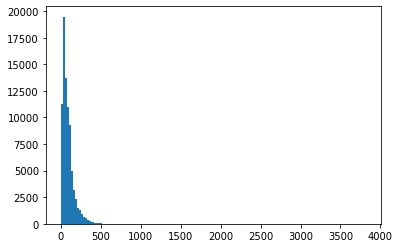

In [0]:
import numpy as np
import random
from matplotlib import pyplot as plt

plt.hist(plot_len_list, bins = 150)

In [0]:
# Keep records with plot lengths between 15 and 545 which correspond to 1% - 99.9% of the dataset
# This reduces our dataframe to 78142 rows instead of 81265

print(df.shape)
df = df.query('plot_len > 15 and plot_len < 545')
print(df.shape)

(81265, 9)
(78142, 9)


In [0]:
# One Hot Encoding the variables

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['genre_list'])
y = multilabel_binarizer.transform(df['genre_list'])

# Print Classes
print(multilabel_binarizer.classes_)

['Action' 'Adult' 'Adventure' 'Animation' 'Biography' 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Family' 'Fantasy' 'Film-Noir' 'Game-Show'
 'History' 'Horror' 'Music' 'Musical' 'Mystery' 'News' 'Reality-TV'
 'Romance' 'Sci-Fi' 'Short' 'Sport' 'Thriller' 'War' 'Western']


In [0]:
# Concatenate One Hot Encoded Columns to our dataset

old_columns = list(df.columns)
new_columns = old_columns + list(multilabel_binarizer.classes_)
df_new = pd.DataFrame(pd.np.column_stack([df, y]))
df_new.columns = new_columns
df_new.head()

,movieid,moviename,year,genre,language,thumbnail,movieplot,genre_list,plot_len,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,tt0007610,'49-'17,1917,"[Drama, Western]",English,https://w266-final-project.s3.amazonaws.com/th...,A judge who had taken part in the gold rush of...,"[Drama, Western]",47,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,tt0005078,The Cheat,1915,"[Drama, Romance]",English,https://w266-final-project.s3.amazonaws.com/th...,"Richard Hardy, a hardworking stockbroker, labo...","[Drama, Romance]",164,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,tt0007257,Reggie Mixes In,1916,"[Action, Comedy, Drama]",English,https://w266-final-project.s3.amazonaws.com/th...,"Reggie, a wealthy young man about town, is eag...","[Action, Comedy, Drama]",67,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,tt0008011,A Girl's Folly,1917,[Comedy],NaN,https://w266-final-project.s3.amazonaws.com/th...,"Living in the country with her widowed mother,...",[Comedy],169,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,tt0003772,Cinderella,1914,"[Fantasy, Drama]",English,https://w266-final-project.s3.amazonaws.com/th...,Based on the fairy tale: Cinderella is mistrea...,"[Fantasy, Drama]",131,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Count the times each genre is present in the dataset
count_genres = df_new.iloc[:,9:].sum().sort_values(ascending=False)
print(count_genres)

Drama          43442.0
Comedy         26912.0
Romance        15486.0
Thriller       15257.0
Action         11848.0
Crime          10336.0
Horror          9224.0
Adventure       6927.0
Mystery         5739.0
Sci-Fi          4705.0
Fantasy         4560.0
Family          4395.0
War             3144.0
History         2437.0
Musical         2330.0
Biography       2138.0
Western         2086.0
Animation       1939.0
Music           1714.0
Sport           1299.0
Film-Noir        696.0
Documentary        6.0
Adult              5.0
Reality-TV         4.0
News               2.0
Short              2.0
Game-Show          1.0
dtype: float64


In [0]:
# Get the top 10 genres
top_genres = df_new.iloc[:,9:].sum().sort_values(ascending=False).iloc[:10]
genre_counts = top_genres.to_dict()

genre_counts

{'Action': 11848.0,
 'Adventure': 6927.0,
 'Comedy': 26912.0,
 'Crime': 10336.0,
 'Drama': 43442.0,
 'Horror': 9224.0,
 'Mystery': 5739.0,
 'Romance': 15486.0,
 'Sci-Fi': 4705.0,
 'Thriller': 15257.0}

In [0]:
# Save this to a csv file
label_names = ['movieid','movieplot','Drama','Thriller','Comedy','Action','Crime',
                'Horror','Romance','Adventure','Mystery','Sci-Fi']
df_new[label_names].Drama.describe()
df_new[label_names].to_csv('/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/data/original_movie_dataset.csv', index=False)

In [0]:
# Load the poster feature vectors
df_poster = pd.read_csv('/content/drive/My Drive/w266-FinalProject/data/posters/poster_features.csv.zip')
df_poster.shape

(81124, 2)

In [0]:
# Merge the poster dataframe with the cleaned movie dataset
df_clean = df_new[label_names].merge(df_poster, how='left', right_on='movieid',left_on='movieid')
df_clean.shape

(78142, 13)

In [0]:
df_clean.head()

,movieid,movieplot,Drama,Thriller,Comedy,Action,Crime,Horror,Romance,Adventure,Mystery,Sci-Fi,feature_vector
0,tt0007610,A judge who had taken part in the gold rush of...,1,0,0,0,0,0,0,0,0,0,"[0.7366994023323059, 0.9941093921661377, 1.076..."
1,tt0005078,"Richard Hardy, a hardworking stockbroker, labo...",1,0,0,0,0,0,1,0,0,0,"[0.002950882539153099, 0.10090522468090057, 1...."
2,tt0007257,"Reggie, a wealthy young man about town, is eag...",1,0,1,1,0,0,0,0,0,0,"[0.03462240472435951, 0.500708818435669, 1.862..."
3,tt0008011,"Living in the country with her widowed mother,...",0,0,1,0,0,0,0,0,0,0,"[0.0, 0.06257307529449463, 0.8574206233024597,..."
4,tt0003772,Based on the fairy tale: Cinderella is mistrea...,1,0,0,0,0,0,0,0,0,0,"[0.2867472171783447, 0.0, 0.9653348922729492, ..."


In [0]:
# Concatenate the labels into a list
NUM_LABELS = 10
start_index = 2
labels = [rows[start_index:NUM_LABELS+start_index].values.tolist() for index,rows in df_clean.iterrows()]

10


78142

In [0]:
df_clean['labels'] = labels
df_clean.head()

,movieid,movieplot,Drama,Thriller,Comedy,Action,Crime,Horror,Romance,Adventure,Mystery,Sci-Fi,feature_vector,labels
0,tt0007610,A judge who had taken part in the gold rush of...,1,0,0,0,0,0,0,0,0,0,"[0.7366994023323059, 0.9941093921661377, 1.076...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,tt0005078,"Richard Hardy, a hardworking stockbroker, labo...",1,0,0,0,0,0,1,0,0,0,"[0.002950882539153099, 0.10090522468090057, 1....","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
2,tt0007257,"Reggie, a wealthy young man about town, is eag...",1,0,1,1,0,0,0,0,0,0,"[0.03462240472435951, 0.500708818435669, 1.862...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0]"
3,tt0008011,"Living in the country with her widowed mother,...",0,0,1,0,0,0,0,0,0,0,"[0.0, 0.06257307529449463, 0.8574206233024597,...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
4,tt0003772,Based on the fairy tale: Cinderella is mistrea...,1,0,0,0,0,0,0,0,0,0,"[0.2867472171783447, 0.0, 0.9653348922729492, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [0]:
# Remove rows where the feature vector is NA
df_merge_clean = df_clean.loc[~df_clean.feature_vector.isna(),:]
df_merge_clean.shape

(78008, 14)

### Save Cleaned Datasets

In [0]:
df_merge_clean[['movieid','movieplot','feature_vector','labels']].to_csv('/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/data/clean_poster_data_'+str(NUM_LABELS) + '.csv', index=False)

In [0]:
np_feature_vector = np.array([np.array(xi) for xi in df_merge_clean.feature_vector.values])
np.save('/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/data/poster_feature_vector.data', np_feature_vector)

In [0]:
np_label_vector = np.array([np.array(xi) for xi in df_merge_clean.labels.values])
np.save('/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/data/poster_labels_'+str(NUM_LABELS) + '.data', np_label_vector)